In [11]:
from os import listdir
from os.path import isfile, join
import numpy as np
from nibabel.testing import data_path
import nibabel as nib
from operator import itemgetter
import seaborn as sns
from sklearn.metrics.cluster import adjusted_mutual_info_score
import matplotlib.pyplot as plt


In [14]:
def Dice_Calculator(file1, file2):
    img1 = nib.load(file1)
    img1_data = img1.get_fdata()
    hdr1 = img1.header
    img1_flat = img1_data.flatten()
    img1_flat = [int(i) for i in img1_flat]

    img2 = nib.load(file2)
    img2_data = img2.get_fdata()
    hdr2 = img2.header
    img2_flat = img2_data.flatten()
    img2_flat = [int(i) for i in img2_flat]
    
    values1 = np.unique(img1_flat)
    values2 = np.unique(img2_flat)
    counts1 = np.array(range(1, len(img1_flat)+1))
    counts2 = np.array(range(1, len(img2_flat)+1))
    counts1 = [int(i) for i in counts1]
    counts2 = [int(i) for i in counts2]

    img1_flatten = list(zip(img1_flat, counts1))
    img2_flatten = list(zip(img2_flat, counts2))

    img1_flatten = sorted(img1_flatten, key = lambda l:l[0])
    img2_flatten = sorted(img2_flatten, key = lambda l:l[0])
    
    img1_cell = [[] for i in range(len(values1))]
    img2_cell = [[] for i in range(len(values2))]
    start = 0
    for i in range(0,len(values1)-1):
        img1_list = [x[0] for x in img1_flatten]
        end = max(loc for loc, val in enumerate(img1_list) if val == values1[i])
        for j in range(start,end):
            img1_cell[i].append(img1_flatten[j][1])  
        start = end+1

    start = 0
    for i in range(0,len(values2)-1):
        img2_list = [x[0] for x in img2_flatten]
        end = max(loc for loc, val in enumerate(img2_list) if val == values2[i])
        for j in range(start,end):
            img2_cell[i].append(img2_flatten[j][1])  
        start = end+1
        
    Dice_scores = np.zeros((len(values1),len(values2)),dtype=float)
    for i in range(0,len(values1)-1):
        for j in range(0,len(values2)-1):
            sims = len(set(img1_cell[i]) & set(img2_cell[j]))
            Dice_scores[i][j] = 2*sims/(len(img1_cell[i])+len(img2_cell[j]))
    
    mean_Dice = Dice_scores.mean()
    return mean_Dice

In [2]:
def NMI_Calculator(file1,file2):
    img1 = nib.load(filename1)
    img1_data = img1.get_fdata()
    img1_flat = img1_data.flatten()
    img1_flat = img1_flat+1
    img1_flat.tolist()
    img1_flat = [int(i) for i in img1_flat]

    img2 = nib.load(filename2)
    img2_data = img2.get_fdata()
    img2_flat = img2_data.flatten()
    img2_flat = img2_flat+1
    img2_flat.tolist()
    img2_flat = [int(i) for i in img2_flat]

    nmi = adjusted_mutual_info_score(img1_flat, img2_flat)
    return nmi
    

In [ ]:
mypath = '../Nifti_images'
files = [f for f in listdir(mypath) if isfile(join(mypath, f))]
[f for f in files if 'DS' not in f]
Dice_scores = np.zeros((len(files)-1,len(files)-1),dtype=float)

for i in range(0,len(files)-2):
    for j in range(i,len(files)-1):
        image1_name = files[i]
        filename1 = join(mypath, image1_name)
        image2_name = files[j]
        filename2 = join(mypath, image2_name)

        Dice_scores[i][j] = Dice_Calculator(filename1, filename2)

sns.heatmap(Dice_scores)

In [ ]:
mypath = '../Nifti_images'
files = [f for f in listdir(mypath) if isfile(join(mypath, f))]
files = [f for f in files if 'DS' not in f]
files = [f for f in files if 'glasser' not in f]
files = [f for f in files if 'pp264' not in f]
NMI_scores = np.zeros((len(files)-1,len(files)-1),dtype=float)

for i in range(0,len(files)-2):
    for j in range(i,len(files)-1):
        image1_name = files[i]
        filename1 = join(mypath, image1_name)
        image2_name = files[j]
        filename2 = join(mypath, image2_name)
        print(i)
        NMI_scores[i][j] = NMI_Calculator(filename1, filename2)

#sns.heatmap(NMI_scores)

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1


In [36]:
mypath = '../Nifti_images'
files = [f for f in listdir(mypath) if isfile(join(mypath, f))]
files = [f for f in files if 'DS' not in f]
files = [f for f in files if 'glasser' not in f]
files = [f for f in files if 'pp264' not in f]
files = [f.split('_')[0] for f in files]
files[5] = 'HOC'
files[6] = 'HOS'
files[8] = 'Princeton'
files[9] = 'Schaefer-1000'
files[10] = 'Schaefer-200'
files[11] = 'Schaefer-300'
files[12] = 'Schaefer-400'
files

['aal',
 'brodmann',
 'CPAC200',
 'desikan',
 'DKT',
 'HOC',
 'HOS',
 'hemispheric',
 'Princeton',
 'Schaefer-1000',
 'Schaefer-200',
 'Schaefer-300',
 'Schaefer-400',
 'Schaefer2018-400-node',
 'Schaefer2018',
 'Schaefer2018',
 'slab1068',
 'slab907',
 'Talairach',
 'tissue',
 'yeo-17-liberal',
 'yeo-17',
 'yeo-7-liberal',
 'yeo-7']

(array([ 0.5,  2.5,  4.5,  6.5,  8.5, 10.5, 12.5, 14.5, 16.5, 18.5, 20.5,
        22.5]), <a list of 12 Text yticklabel objects>)

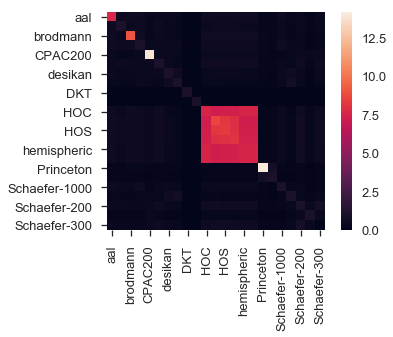

In [37]:
sns.set(style="ticks", context="talk")
fig, ax = plt.subplots()
plt.style.use("dark_background")

backup = NMI_scores

i_lower = np.tril_indices(22, -1)
NMI_scores[i_lower] = NMI_scores.T[i_lower]
        
with sns.axes_style("white"):
    ax = sns.heatmap(NMI_scores, square=True)
    
labels = [item.get_text() for item in ax.get_xticklabels()]
labels = files

ax.set_xticklabels(labels)
ax.set_yticklabels(labels)

plt.xticks(rotation=90)
plt.yticks(rotation=0)